# Модель построения сеймических изображений

## Содержание

* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Подбор оптимального положения бинов](#Подбор-оптимального-положения-бинов)
* [Выравнивание трасс для суммирования](#Выравнивание-трасс-для-суммирования)
    * [Обучение модели выделения моментов первых вступлений](#Обучение-модели-выделения-моментов-первых-вступлений)
    * [Массовая обработка сейсмограмм](#Массовая-обработка-сейсмограмм)
* [Сборка суммированных сейсмограмм](#Сборка-суммированных-сейсмограмм)

## Постановка задачи

Построить суммированную сейсмограмму из набора полевых 2D сейсмограмм общего пункта взрыва (ОПВ).

## Датасет

2D сейсмограммы валынтойского участка.

Загрузка SPS файлов

In [1]:
import sys
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

sys.path.append('..')

from dataset import Dataset, Pipeline, B, V, F

from geolog import SeismicBatch, FieldIndex, get_file_by_index, Layouts
from geolog.models import HMModel, make_hmm_data

dfr = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_R_utm.txt', sep='\s+', header=None)
dfr.columns = ['rline', 'rid', 'x', 'y', 'z']
dfr = dfr.astype({'rid': np.int32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfs = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_S_utm.txt', sep='\s+', header=None)
dfs.columns = ['sline', 'sid', 'point_index', 'sht_depth', 'uphole', 'x', 'y', 'z']
dfs = dfs.dropna(axis=0)
dfs = dfs.astype({'sid': np.int32, 'point_index': np.int8, 'sht_depth': np.float32,
                  'uphole': np.float32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfx = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_X.sps',
                  sep='\s+', header=None, skiprows=49)
dfx.columns = ['tape', 'xid', 'sline', 'sid', 'from_channel', 'to_channel', 'rline',
               'from_receiver', 'to_receiver']
dfx['sline'] = dfx['sline'].apply(lambda x: "S" + str(x))
dfx['rline'] = dfx['rline'].apply(lambda x: "R" + str(x))
dfx = dfx.astype({'xid': np.int32, 'sid': np.int32,
                  'from_channel': np.int16, 'to_channel': np.int16,
                  'from_receiver': np.int32, 'to_receiver': np.int32})

Просмотр схемы расположения ПП и ПВ и отработанного профиля S37

<IPython.core.display.Javascript object>


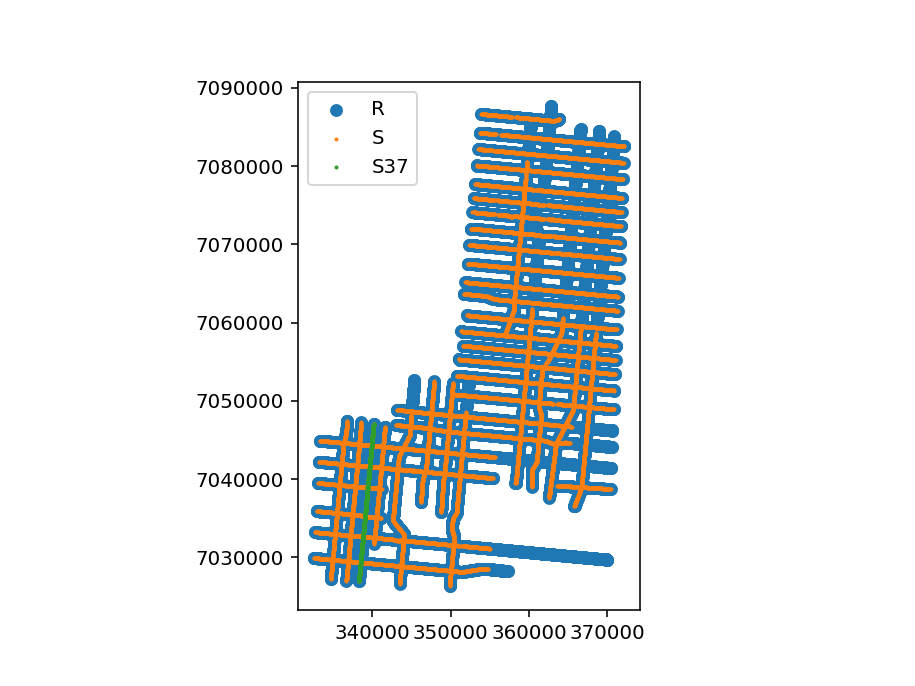

In [2]:
%matplotlib notebook

(Layouts()
 .add(*dfr[['x', 'y']].values.T, label='R', s=30)
 .add(*dfs[['x', 'y']].values.T, label='S', s=1)
 .add(*dfs[dfs['sline'] == 'S37'][['x', 'y']].values.T, label='S37', s=1)
 .show()
)

Фильтрация отработанного профиля

In [3]:
dfx37 = dfx[dfx['sline'] == 'S37']

Индексация исходных сейсмограмм ОПВ

In [4]:
shot_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx37)

Датасет сейсмограмм ОПВ

In [5]:
shot_set = Dataset(shot_index, SeismicBatch)

Загрузка набора сейсмограмм ОПВ

In [6]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/*sgy'

batch = (shot_set.next_batch(15)
         .load(path=path, fmt='segy', sort_by='channel',
               get_file_by_index=get_file_by_index, skip_channels=2)
         .to_2d())

Просмотр одной из сейсмограмм ОПВ

<IPython.core.display.Javascript object>


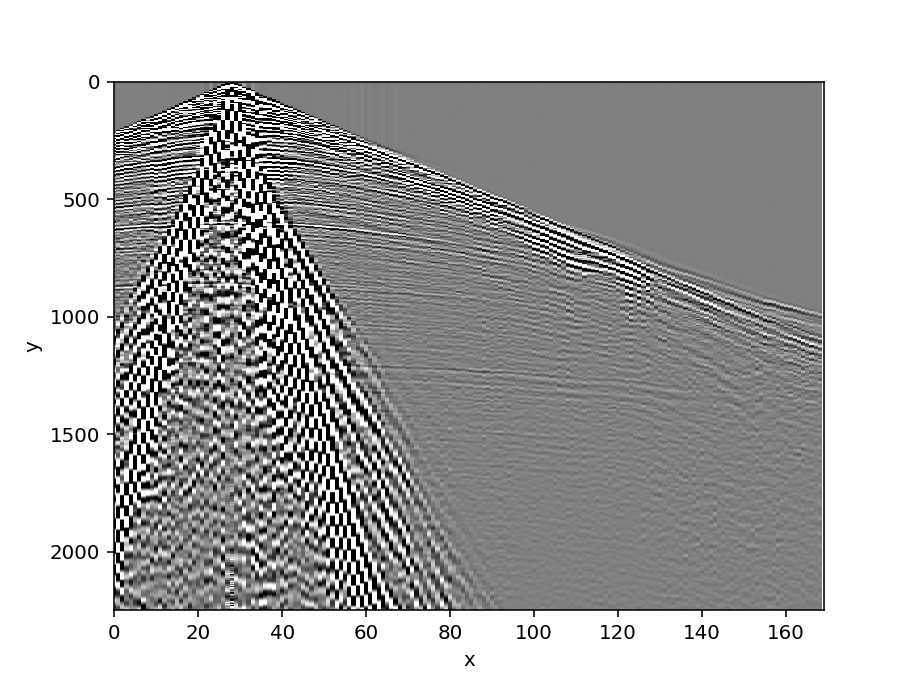

In [7]:
%matplotlib notebook

cv = 3
batch.show_slice(batch.indices[14], vmin=-cv, vmax=cv, cmap="gray")

## Подбор оптимального положения бинов

Запуск процедуры оптимизации положения бинов и индексации сейсмограмм общей средней точки (ОСТ)

In [8]:
bin_size = 25

bins_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx37, bin_size=bin_size, iters=100)

Просмотр степени равномерности распределения числа трасс между бинами

<IPython.core.display.Javascript object>


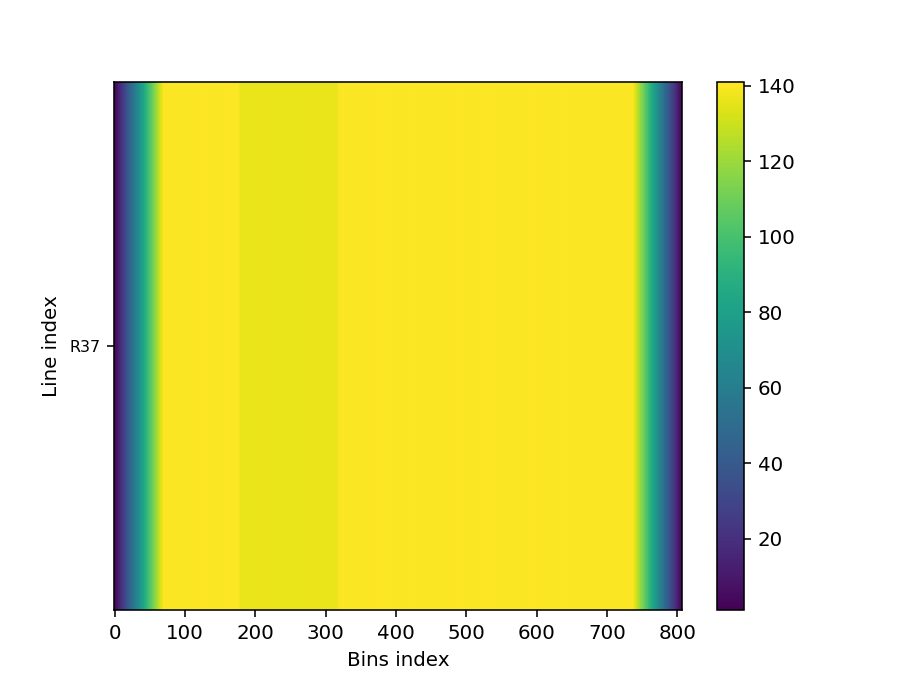

In [9]:
%matplotlib notebook

bins_index.show_heatmap()

Задание датасета сейсмограмм ОСТ

In [10]:
bins_set = Dataset(bins_index, SeismicBatch)

Загрузка набора сейсмограмм ОСТ

In [11]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/*sgy'

batch = (bins_set.next_batch(5)
        .load(path=path, fmt='segy', get_file_by_index=get_file_by_index, skip_channels=2)
        .to_2d())

Просмотр одной из сейсмограмм ОСТ

<IPython.core.display.Javascript object>


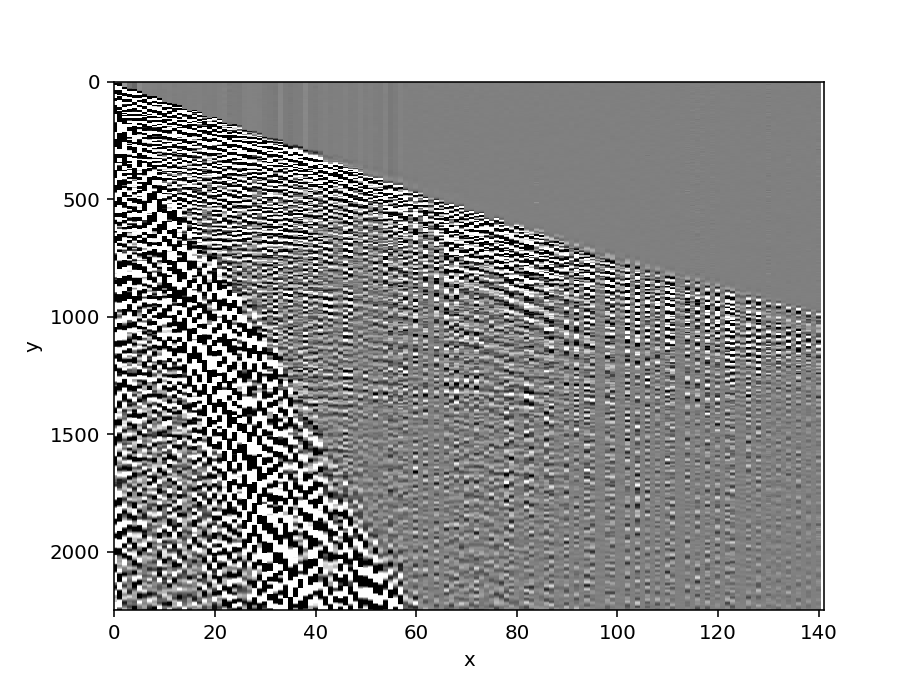

In [12]:
%matplotlib notebook

cv = 1
batch.show_slice(batch.indices[3], vmin=-cv, vmax=cv, cmap="gray")

## Выравнивание трасс для суммирования

### Обучение модели выделения моментов первых вступлений

Задание обучающей выборки для определения моментов первых вступлений

In [13]:
bins_set.split(shares=5/len(bins_set), shuffle=True)

Конфигурация модели

In [14]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=100, covariance_type="full")
}

Пайплайн обучения модели

In [15]:
batch_size = 5
cv = 3

train_pipeline = (Pipeline()
                 .init_model("dynamic", HMModel, "HMM", config=config_train)
                 .load(path=path, fmt='segy', sort_by='channel',
                       get_file_by_index=get_file_by_index, skip_channels=2)
                 .to_2d(length_alingment='min')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="traces", dst="traces")
                 .gradient(src="traces", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .train_model("HMM", make_data=partial(make_hmm_data, components='wavelet'))
                 .run(batch_size=batch_size, n_epochs=1, shuffle=False, drop_last=False, lazy=True))

Запуск обучения модели

In [16]:
(bins_set.train >> train_pipeline).run()

Сохранение обученной модели

In [18]:
hmmodel_path = "picks_model.dill"

train_pipeline.save_model("HMM", path=hmmodel_path)

Кофигурация модели для инференса

In [19]:
config_predict = {
    'build': False,
    'load': {'path': hmmodel_path}
}

with open(hmmodel_path, "rb") as file:
    hmmodel = dill.load(file)
signal_label = np.argmin(hmmodel.startprob_)

def get_first_arrival(arr, signal_label):
    indices = np.where(arr == signal_label)[0]
    return indices[0] if len(indices) else -1

Тестовый пайплайн для оценки модели выделения моментов первых вступлений

In [20]:
batch_size = 5

test_pipeline = (Pipeline()
                 .init_model("static", HMModel, "HMM", config=config_predict)
                 .load(path=path, fmt='segy', sort_by='channel',
                       get_file_by_index=get_file_by_index, skip_channels=2)
                 .to_2d(length_alingment='min')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="traces", dst="traces")
                 .gradient(src="traces", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .predict_model("HMM", make_data=partial(make_hmm_data, components='wavelet'),
                                save_to=B("hmm_predictions"), mode='w')
                 .apply_to_each_channel(get_first_arrival, src="hmm_predictions",
                                        dst="hmm_predictions", signal_label=signal_label)
                 .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True))

Запуск тестового пайплайна

In [21]:
test_batch = (bins_set.train >> test_pipeline).next_batch()

Просмотр отмеченный моментов первых вступлений

<IPython.core.display.Javascript object>


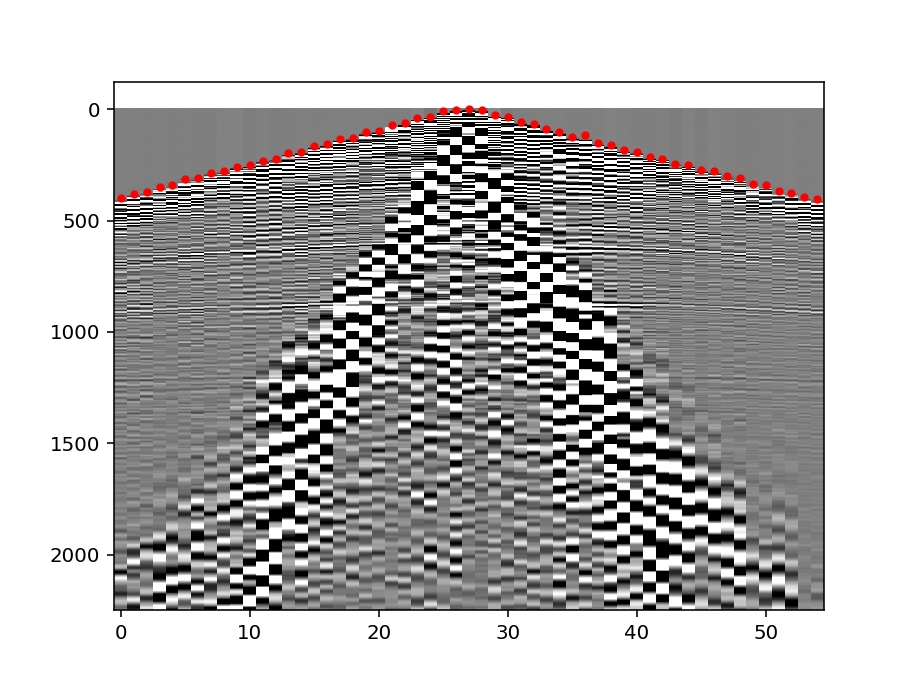

In [22]:
%matplotlib notebook

i = 3
picks = test_batch.hmm_predictions[i]

plt.imshow(test_batch.traces[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

### Массовая обработка сейсмограмм

Полный пайплайн загрузки, выравнивания и суммирования трасс

In [23]:
cv = 3
batch_size = 10

predict_pipeline = (Pipeline()
                   .init_model("static", HMModel, "HMM", config=config_predict)
                   .init_variable('stacked_traces', init_on_each_run=list)
                   .load(path=path, fmt='segy', sort_by='channel',
                         get_file_by_index=get_file_by_index, skip_channels=2)
                   .to_2d()
                   .apply_transform(np.clip, a_min=-cv, a_max=cv, src="traces", dst="traces")
                   .gradient(src="traces", dst="grad")
                   .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                   .predict_model("HMM", make_data=partial(make_hmm_data, components='wavelet'),
                                  save_to=B("hmm_predictions"), mode='w')
                   .apply_to_each_channel(get_first_arrival, src="hmm_predictions",
                                          dst="hmm_predictions", signal_label=signal_label)
                   .shift_traces(shift_src="hmm_predictions")
                   .to_2d(length_alingment='min')
                   .summarize()
                   .update_variable('stacked_traces', B('traces'), mode='e') 
                   .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True))

Запуск пайплайна

In [24]:
(bins_set >> predict_pipeline).run()

Сбор суммированных трасс

In [25]:
res = predict_pipeline.get_variable('stacked_traces')

Группировка суммированных трасс в сейсмограммы

In [26]:
lines, bins_pos = np.array([i.split('/') for i in bins_set.indices[:len(res)]]).T
bins_pos = bins_pos.astype(int)

df = pd.DataFrame(dict(traces=res), pd.MultiIndex.from_arrays([lines, bins_pos]))
df = df.sort_index(level=[0, 1])

src = df.groupby(level=0)['traces'].apply(lambda x: np.array([i.ravel() for i in x])).to_frame()
src['meta'] = [dict(sorting=None)] * len(src)

## Сборка суммированных сейсмограмм

Задание датасета суммированных сейсмограмм

In [27]:
stacked_index = mp_index.convert_to_stacked()
stacked_set = Dataset(stacked_index, SeismicBatch)

Загрузка суммированной сейсмограммы

In [28]:
stacked_batch = stacked_set.next_batch(1).load(src=src).to_2d(length_alingment='min')

Просмотр суммированной сейсмограммы

<IPython.core.display.Javascript object>


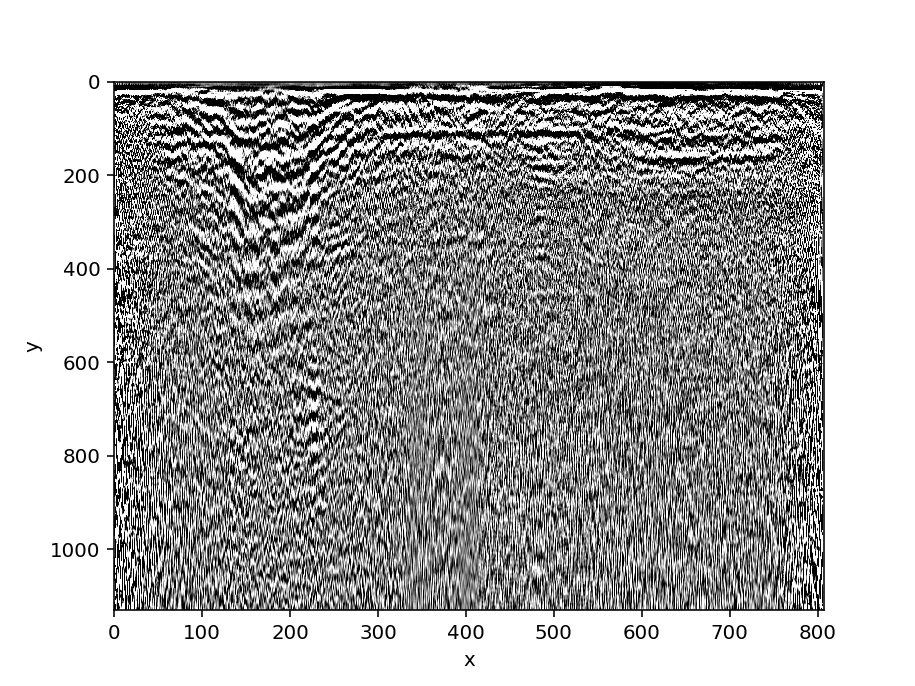

In [29]:
%matplotlib notebook

cv = 0.1
stacked_batch.show_slice(stacked_batch.indices[0], vmin=-cv, vmax=cv, cmap='gray')